In [35]:
from matplotlib import pyplot as plt
import os
import csv
import pandas as pd
import numpy as np
import cv2
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from mpl_toolkits.mplot3d import Axes3D, art3d 


In [40]:
# file_path = 'hand_labels_hsv_train.csv'
file_path = 'hand_labels_hsv_1img.csv'

df = pd.read_csv(file_path)

# removing 1st column containing label name ('orange cone')
df = df.drop(df.columns[0], axis=1)

x_train = df.to_numpy()

In [41]:
####### Computing GMM training parameters where num gaussians (k) == 1 ####

### Solution: caulculate sample mean and sample covariance matrix for data which maximize the siplified objective function ####

print(x_train.shape)

mu = np.mean(x_train, axis=0).flatten()
print(mu)

Sigma = np.cov(x_train.T)
print(Sigma)

(215, 3)
[  4.69302326 235.46976744 160.12093023]
[[ 579.24177353   24.81777874  -94.43933927]
 [  24.81777874  201.61473593 -110.24399044]
 [ -94.43933927 -110.24399044  201.75166268]]


In [42]:
from scipy.stats import multivariate_normal #### ONLY USED FOR TESTING ####

In [43]:
#### gaussian function to make prediction ######
def single_point_gaussian_pdf(x, mu, Sigma):
    k = mu.shape[0]  # Dimensionality
    Sigma_det = np.linalg.det(Sigma)  
    Sigma_inv = np.linalg.inv(Sigma)  
    norm_const = 1.0 / (np.power((2*np.pi), k/2) * np.sqrt(Sigma_det))
    
    # Exponent
    diff = np.matrix(x - mu)
    exp_value = np.exp(-0.5 * (diff * Sigma_inv * diff.T))
    
    return (norm_const * exp_value).item()


#### testing ####
max_pdf = 0.0, None
for x in x_train:
    y = single_point_gaussian_pdf(x, mu, Sigma)
    if y > max_pdf[0]:
        max_pdf = y, x
    # print(x)
    # print("Actual: ", single_point_gaussian_pdf(x, mu, Sigma))
    # print("Expected: ", multivariate_normal.pdf(x, mean=mu, cov=Sigma))
print("Actual: ", max_pdf)
print("Expected: ", multivariate_normal.pdf(max_pdf[1], mean=mu, cov=Sigma))

Actual:  (1.6209386008845087e-05, array([  2, 236, 160]))
Expected:  1.6209386008845083e-05


In [45]:
print(single_point_gaussian_pdf(mu, mu, Sigma))

1.6331123484698466e-05


In [36]:
## function for plotting my gaussians
def plot_ellipse(mu, Sigma, ax, n_std=2.0, edgecolor='red', **kwargs):
    """
    Adjusted plot_ellipse function for 2D projections in a 3D plot.
    """
    # Perform eigen decomposition on the covariance matrix
    eigenvals, eigenvecs = np.linalg.eigh(Sigma)
    largest_eigenval_index = np.argmax(eigenvals)
    largest_eigenvec = eigenvecs[:, largest_eigenval_index]
    angle = np.arctan2(largest_eigenvec[1], largest_eigenvec[0])
    angle = np.degrees(angle)
    width, height = 2 * n_std * np.sqrt(eigenvals)

    # For 3D plot, we plot the ellipse as a 2D patch at a fixed z (Value) level
    ellipse = Ellipse(xy=mu, width=width, height=height, angle=angle, edgecolor=edgecolor, **kwargs)
    
    # Transform ellipse to the plane
    trans = transforms.Affine2D().rotate_deg(angle).translate(mu[0], mu[1])
    ax.add_patch(ellipse)
    art3d.pathpatch_2d_to_3d(ellipse, z=0, zdir="z")

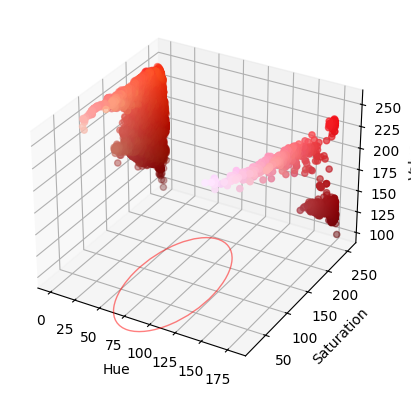

In [37]:
# Original plot code with modifications to include the ellipse
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors_rgb = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_HSV2RGB)[0][0] for color in x_train]
hs = [color[0] for color in x_train]  
ss = [color[1] for color in x_train]  
vs = [color[2] for color in x_train] 
colors_normalized = [[r/255, g/255, b/255] for r, g, b in colors_rgb]
ax.scatter(hs, ss, vs, color=colors_normalized)

# Plot the ellipse on the HS plane
mu_hs = mu[:2] 
Sigma_hs = Sigma[:2, :2] 
plot_ellipse(mu_hs, Sigma_hs, ax, facecolor='none', alpha=0.5)

ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
plt.savefig('hsv_with_ellipse.png')

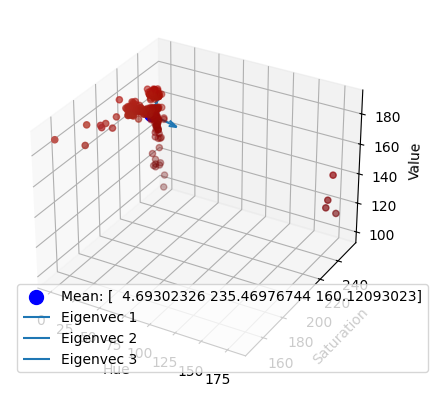

In [44]:
eigenvalues, eigenvectors = np.linalg.eig(Sigma)

# Original plot code with modifications to include the ellipse
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors_rgb = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_HSV2RGB)[0][0] for color in x_train]
hs = [color[0] for color in x_train]  
ss = [color[1] for color in x_train]  
vs = [color[2] for color in x_train] 
colors_normalized = [[r/255, g/255, b/255] for r, g, b in colors_rgb]
ax.scatter(hs, ss, vs, color=colors_normalized)

# Plot mu
ax.scatter([mu[0]], [mu[1]], [mu[2]], color='blue', s=100, label=f'Mean: {mu}')

# Plot eigenvectors
for i in range(len(eigenvalues)):
    # Scale the eigenvectors by the square root of their eigenvalues (standard deviation)
    vec_end = mu + np.sqrt(eigenvalues[i]) * eigenvectors[:, i]
    ax.quiver(mu[0], mu[1], mu[2], eigenvectors[0, i], eigenvectors[1, i], eigenvectors[2, i], length=np.sqrt(eigenvalues[i]), normalize=True, label=f'Eigenvec {i+1}')

ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
plt.legend()
plt.savefig('hsv_with_mu_sigma_1img.png')

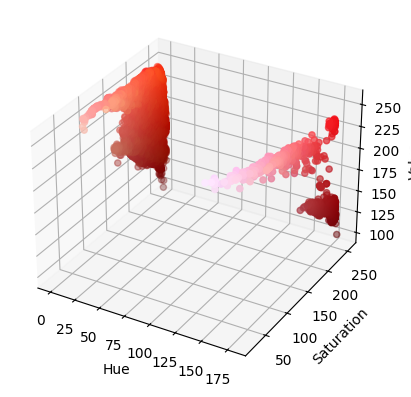

In [29]:
#### plotting pre-lookup table ######

mu = mu # precomputed, want to place on scatter plot below
Sigma = Sigma # precomputed, want to place on scatter plot below

# First HSV plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Convert each HSV color in the list to RGB
colors_rgb = [cv2.cvtColor(np.uint8([[color]]), cv2.COLOR_HSV2RGB)[0][0] for color in x_train]

hs = [color[0] for color in x_train]  
ss = [color[1] for color in x_train]  
vs = [color[2] for color in x_train] 
colors_normalized = [[r/255, g/255, b/255] for r, g, b in colors_rgb] # need to normalize for matplotlib apparently
ax.scatter(hs, ss, vs, color=colors_normalized)

# # Set the range for each axis to match the HSV ranges
# ax.set_xlim([0, 180])  # Hue range
# ax.set_ylim([0, 255])  # Saturation range
# ax.set_zlim([0, 255])  # Value range  

ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')



plt.savefig('hsv_simple_NB.png')


In [48]:
### compute and predictions using a lookup table ####

# Convert HSV values to 5-bit equivalents
def hsv_to_5bit(h, s, v):
    h_5bit = int((h / 180.0) * 31)  # Hue range of 0-180
    s_5bit = int((s / 255.0) * 31)  # Saturation range of 0-255
    v_5bit = int((v / 255.0) * 31)  # Value range of 0-255
    return h_5bit, s_5bit, v_5bit

def five_bit_to_hsv(h_5bit, s_5bit, v_5bit):
    # Convert back from 5-bit to original HSV scale
    h = (h_5bit / 31.0) * 180  
    s = (s_5bit / 31.0) * 255 
    v = (v_5bit / 31.0) * 255
    return h, s, v

# Function to initialize the 32x32x32 lookup table
def create_lookup_table():
    lookup_table = np.zeros((32, 32, 32), dtype=np.float64)  # Using float64 to maintain small values
    for h5 in range(32):
        for s5 in range(32):
            for v5 in range(32):
                h, s, v = five_bit_to_hsv(h5, s5, v5)
                x = np.array([h, s, v], dtype=np.float64)
                # filling in the lookup table with gaussian pdf value
                lookup_table[h5, s5, v5] = single_point_gaussian_pdf(x, mu, Sigma)
    return lookup_table

def create_test_lookup_table():
    lookup_table = np.zeros((32, 32, 32), dtype=np.float64)  # Using 
    for h5 in range(32):
        for s5 in range(32):
            for v5 in range(32):
                h, s, v = five_bit_to_hsv(h5, s5, v5)
                x = np.array([h, s, v], dtype=np.float64)
                # filling in the lookup table with gaussian pdf value
                lookup_table[h5, s5, v5] = multivariate_normal.pdf(x, mean=mu, cov=Sigma)
    return lookup_table

# Function to query the lookup table with HSV values
def query_lookup_table(h, s, v, lookup_table):
    h_5bit, s_5bit, v_5bit = hsv_to_5bit(h, s, v)
    return lookup_table[h_5bit, s_5bit, v_5bit]

lookup_table = create_lookup_table()
# print("Actual:", lookup_table)

lt_res = query_lookup_table(2, 237, 160, lookup_table)

print(lt_res)

# for pdf in lookup_table.flatten():
#     if pdf > 0:
#         print("nonzero pdf: ", pdf)

## only used for testing my functions
lookup_table_test = create_test_lookup_table()
# print("Expected: ", lookup_table_test)

np.testing.assert_allclose(lookup_table, lookup_table_test)

1.2342450592810571e-05


In [49]:
##### Save Lookup Table to file ####
fn = 'lookup_table_naive_1img'

np.save(f'{fn}.npy', lookup_table)

## saving flattened version to .txt file
lookup_table_flattened = lookup_table.flatten()
np.savetxt(f'{fn}.txt', lookup_table_flattened)